# Part 1- Building a Basic NN

### Loading libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

### Reading the dataset.csv file

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


### Data Cleaning

In [4]:
# convert the 7 columns to float type using to_numeric
df[['f1', 'f2', 'f4', 'f5', 'f6', 'f7']] = df[['f1', 'f2', 'f4', 'f5', 'f6', 'f7']].apply(pd.to_numeric, errors='coerce')

# filter the DataFrame on the 7 columns and delete those rows
df = df.loc[df[['f1', 'f2', 'f4', 'f5', 'f6', 'f7']].notna().all(axis=1)]

In [5]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.834211,120.969737,69.119737,20.507895,80.234211,31.998684,0.473250,0.350000
std,3.364762,32.023301,19.446088,15.958029,115.581444,7.899724,0.332277,0.477284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.300000,0.243750,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.375500,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


### Preprocessing the Dataset

In [6]:
# Extract the features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Scale the numerical variables
numerical_cols = ['f1', 'f2', 'f3', 'f4','f5', 'f6', 'f7']
scaler = StandardScaler()
X = scaler.fit_transform(X[numerical_cols])
X = pd.DataFrame(X, columns=numerical_cols)


# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


For this dataset, I would suggest the following NN architecture:

Input layer: 7 neurons (corresponding to the 7 features)
Hidden layers: 2 layers, each with 64 nodes and ReLU activation function
Output layer: 1 neuron with sigmoid activation function (for binary classification)

This architecture has a total of 764 + 6464 + 64*1 = 4352 parameters to be learned.

###  Defining the Neural Network

In [239]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


class NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(7, 64)
        self.hidden_layer1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden_layer2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        x = self.output_activation(self.hidden_layer2(x))
        return x


### Training Neural Network

In [240]:
# set up the training loop
num_epo = 40 
batch_size = 30
learning_rate = 0.01
net = NeuralNetwork(0)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# In the below list, train loss, test loss, accuracy and training time of each epoch will be saved
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
train_accuracy_list=[]
training_time_list = []

for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    correct_predict_train=0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        # get a batch of training data and labels
        inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, label.view(-1,1))
        loss.backward()
        optimizer.step()

        # calculate statistics for test data
        epo_loss += loss.item()        
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        test_data = torch.Tensor(y_test.iloc[i:i+batch_size].values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted data
        predicted = (test_output > 0.5).float()
        correct_predict += (predicted == test_data).sum().item()
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        
        
        # calculate statistics for train data
        train_input = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        train_output = net(train_input)
        # convert probabilities to predicted data
        predicted = (train_output > 0.5).float()
        train_data = torch.Tensor(y_train.iloc[i:i+batch_size].values).view(-1,1)
        correct_predict_train += (predicted == train_data).sum().item()

    # calculate the training accuracy for the epoch
    train_accuracy = correct_predict_train / len(X_train)
    
    # calculate epoch train loss, test loss, training time and accuracy
    train_loss = epo_loss / len(X_train)
    test_loss = criterion(net(torch.Tensor(X_test.values)), 
                                torch.Tensor(y_test.values).view(-1,1)).item()
    test_accuracy = correct_predict / len(X_test)
    epo_time = time.time() - start_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)
    training_time_list.append(epo_time)

    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, test accuracy: %.3f, train accuracy: %.3f,Training time: %.3f sec' % 
          (epoch + 1, train_loss, test_loss, test_accuracy, train_accuracy, epo_time))






Epoch 1 - Train_loss: 0.024, Test loss: 0.695, test accuracy: 0.447, train accuracy: 0.535,Training time: 0.089 sec
Epoch 2 - Train_loss: 0.024, Test loss: 0.684, test accuracy: 0.553, train accuracy: 0.607,Training time: 0.081 sec
Epoch 3 - Train_loss: 0.023, Test loss: 0.675, test accuracy: 0.625, train accuracy: 0.651,Training time: 0.089 sec
Epoch 4 - Train_loss: 0.023, Test loss: 0.668, test accuracy: 0.664, train accuracy: 0.648,Training time: 0.066 sec
Epoch 5 - Train_loss: 0.023, Test loss: 0.661, test accuracy: 0.658, train accuracy: 0.648,Training time: 0.079 sec
Epoch 6 - Train_loss: 0.023, Test loss: 0.656, test accuracy: 0.658, train accuracy: 0.648,Training time: 0.082 sec
Epoch 7 - Train_loss: 0.023, Test loss: 0.651, test accuracy: 0.658, train accuracy: 0.648,Training time: 0.089 sec
Epoch 8 - Train_loss: 0.022, Test loss: 0.646, test accuracy: 0.658, train accuracy: 0.648,Training time: 0.081 sec
Epoch 9 - Train_loss: 0.022, Test loss: 0.641, test accuracy: 0.658, tra

### Calculate total accuracy, total training time, final test loss of the model

In [241]:
#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test.values)
    test_data = torch.Tensor(y_test.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    Total_accuracy = correct *100/ len(test_data)

    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % test_loss_list[-1])
print('Total training time of model: %.3f sec' % sum(training_time_list))
print('Total accuracy of model: %.3f' % Total_accuracy)

Final test loss: 0.529
Total training time of model: 3.349 sec
Total accuracy of model: 76.974


### Calculate the confusion matrix

In [242]:
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    test_inputs = torch.Tensor(X_test.values)
    test_given = y_test.values
    test_outputs = net(test_inputs)
    predicted_labels = (test_outputs > 0.5).float().numpy().flatten()
    cm = confusion_matrix(test_given, predicted_labels)
    print('Confusion matrix:')
    print(cm)


Confusion matrix:
[[91  9]
 [26 26]]


### Plotting Comparison of Training Accuracy and Test Accuracy and Comparison of Training loss and Testing loss

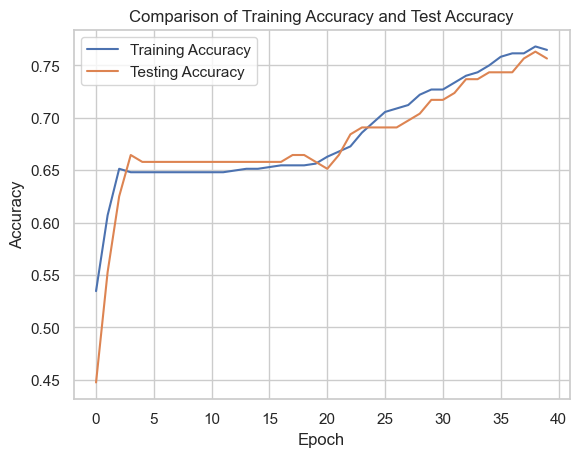

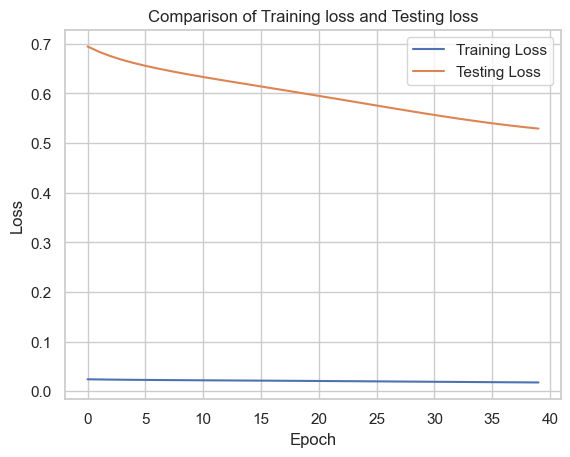

In [243]:
import matplotlib.pyplot as plt

# plot accuracy curves
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Accuracy and Test Accuracy')
plt.legend()
plt.show()

# plot loss curves
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training loss and Testing loss')
plt.legend()
plt.show()

### Save the weights of trainined neural network model

In [244]:
# save the weights
torch.save(net.state_dict(), 'Vaishali_Jain_assignment2_part1.h5')

# Part II: Optimizing NN 

Based on your NN model defined in Part I, tuning the hyperparameters and applying different tools to increase the accuracy. <br>
Using 3 different values of Dropout in the above build NN structure and all other parameters.<br>
### Dropout

Dropout: 0.2,Total accuracy of model: 73.684


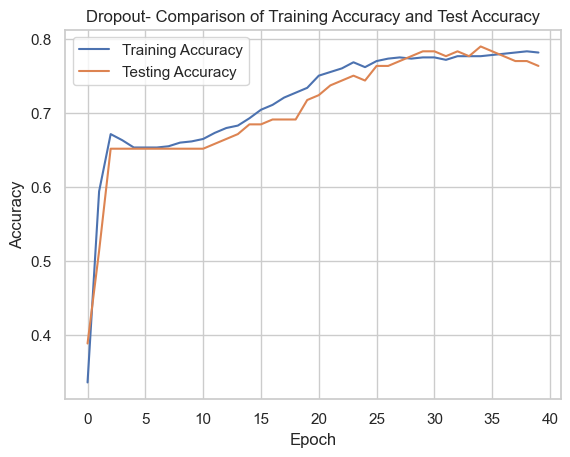

Dropout: 0,Total accuracy of model: 75.000


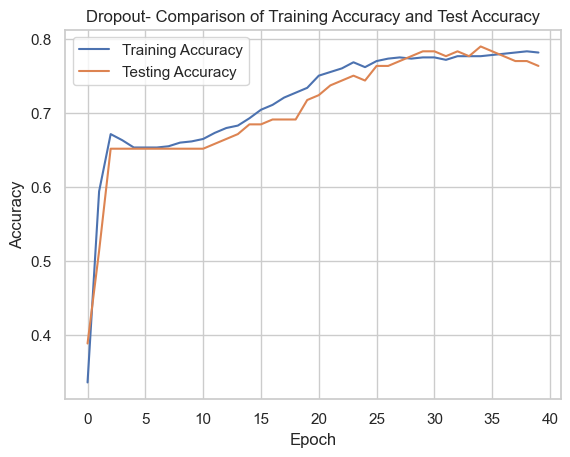

Dropout: 0.1,Total accuracy of model: 75.000


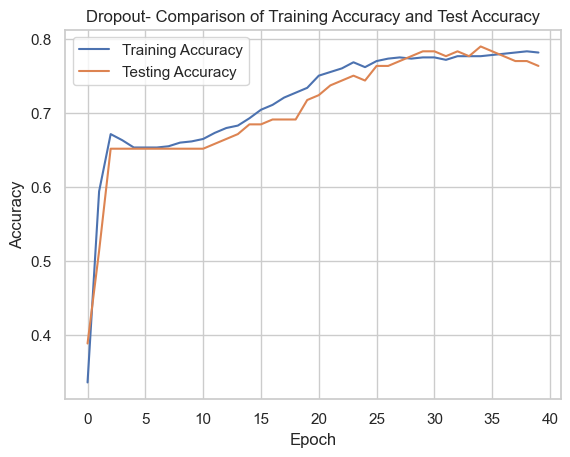

In [220]:
drop_out = [0.2, 0, 0.1]
for p in drop_out:
    # set up the training loop
    num_epo = 40 
    batch_size = 30
    learning_rate = 0.01
    net = NeuralNetwork(p)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    for epoch in range(num_epo):
        epo_loss = 0.0
        correct_predict = 0
        start_time = time.time()
        for i in range(0, len(X_train), batch_size):
            # get a batch of training data and labels
            inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
            label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(inputs)
            loss = criterion(output, label.view(-1,1))
            loss.backward()
            optimizer.step()

    #Calculate total accuracy of model 
    with torch.no_grad():
        test_input = torch.Tensor(X_test.values)
        test_data = torch.Tensor(y_test.values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted labels
        predictions = (test_output > 0.5).float()
    
        # calculate accuracy
        correct= (predictions == test_data).sum().item()
        Total_accuracy = correct*100 / len(test_data)

    print('Dropout: {},Total accuracy of model: {:.3f}'.format(p, Total_accuracy))
    
    # plot accuracy curves
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(test_accuracy_list, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Dropout- Comparison of Training Accuracy and Test Accuracy')
    plt.legend()
    plt.show()

### Optimizer

Testing accuracy with Adam: 69.73684210526316


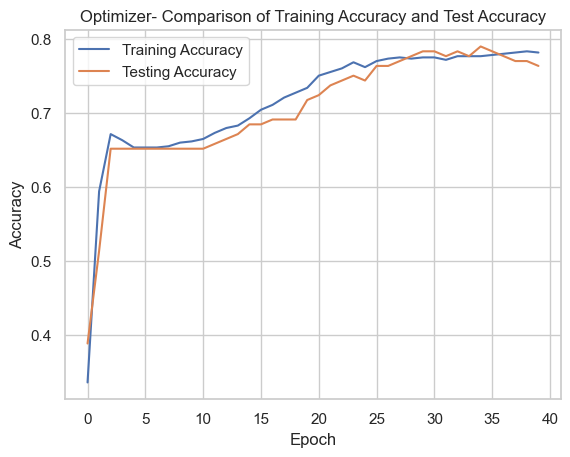

Testing accuracy with SGD: 65.78947368421052


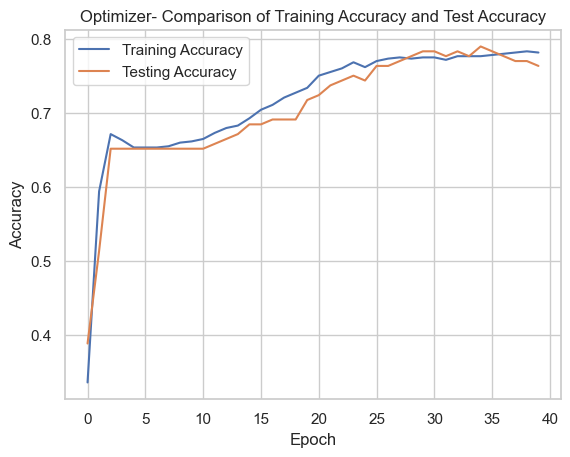

Testing accuracy with RMSprop: 65.13157894736842


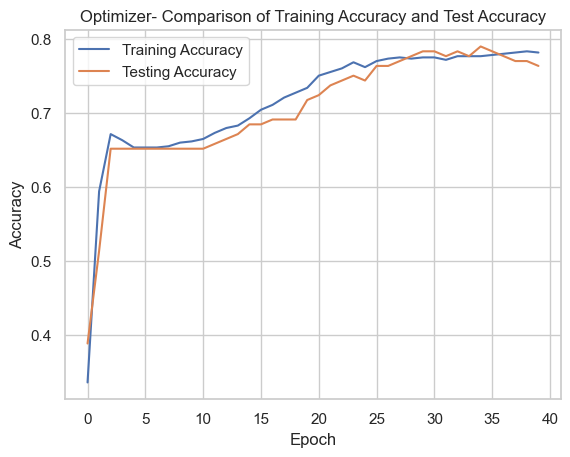

In [221]:
batch_size = 32
num_epochs = 50
learning_rate = 0.01
net = NeuralNetwork(0)
criterion = nn.BCELoss()

# set up different optimizers to try
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
results = {}

# iterate through each optimizer and train the model
for optimizer_fn in optimizers:
    optimizer = optimizer_fn(net.parameters(), lr=learning_rate)
    running_loss = 0.0
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            # get a batch of training data and labels
            inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
            labels = torch.Tensor(y_train.iloc[i:i+batch_size].values)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.view(-1,1))
            loss.backward()
            optimizer.step()

    # evaluate the performance of the model on the testing data
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test.values)
        test_labels = torch.Tensor(y_test.values).view(-1,1)
        test_outputs = net(test_inputs)
        # convert probabilities to predicted labels
        predicted_labels = (test_outputs > 0.5).float()

        # calculate accuracy
        correct_predictions = (predicted_labels == test_labels).sum().item()
        total_predictions = len(test_labels)
        accuracy = correct_predictions*100 / total_predictions
        results[optimizer_fn.__name__] = accuracy
        print(f'Testing accuracy with {optimizer_fn.__name__}: {accuracy}')
        
        # plot accuracy curves
        plt.plot(train_accuracy_list, label='Training Accuracy')
        plt.plot(test_accuracy_list, label='Testing Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Optimizer- Comparison of Training Accuracy and Test Accuracy')
        plt.legend()
        plt.show()



### Activation Function

In [222]:
class NeuralNetwork(nn.Module):

    def __init__(self, dropout_prob,output_activation_fn):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(7, 64)
        self.hidden_layer1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden_layer2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
        if output_activation_fn == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation_fn == 'softmax':
            self.output_activation = nn.Softmax(dim=1)
        elif output_activation_fn == 'tanh':
            self.output_activation = nn.Tanh()
        else:
            raise ValueError('Invalid output activation function')

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.output_activation(self.hidden_layer2(x))
        return x

Activation function: sigmoid,Total accuracy of model: 75.000


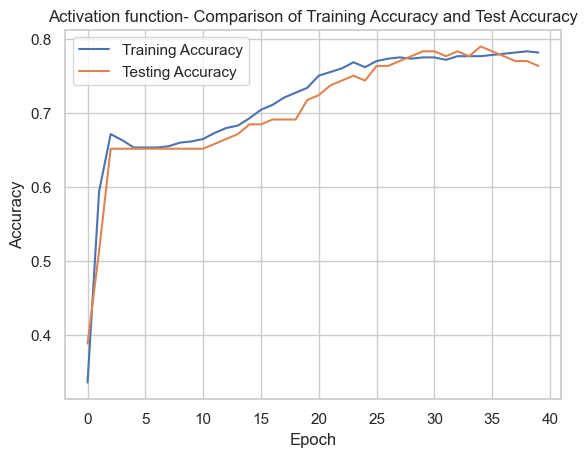

Activation function: softmax,Total accuracy of model: 34.211


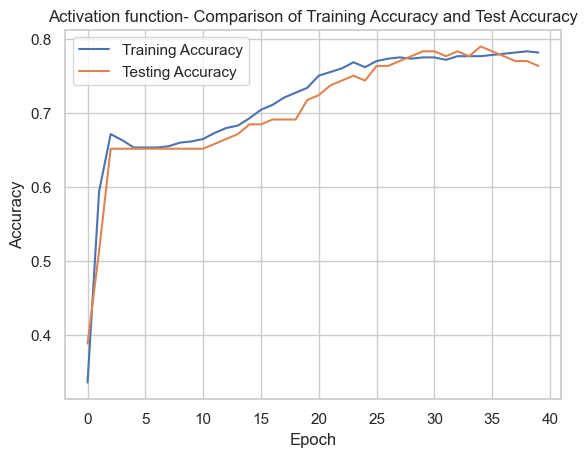

Activation function: tanh,Total accuracy of model: 39.474


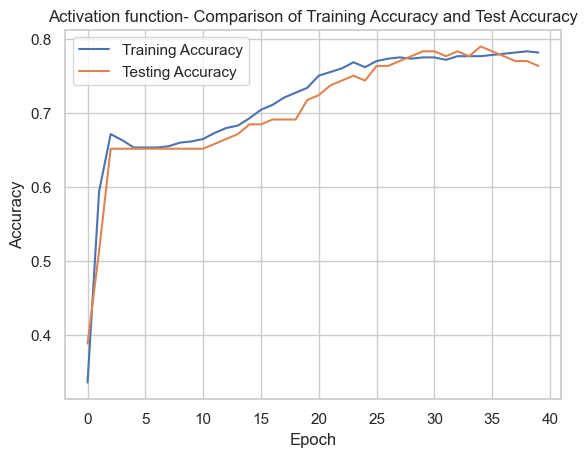

In [223]:
activation_fn = ['sigmoid', 'softmax', 'tanh']
for a in activation_fn:
    # set up the training loop
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.01
    net = NeuralNetwork(dropout_prob=0, output_activation_fn=a)
    if a == 'tanh':
        criterion = nn.MSELoss()
    else:
        criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            # get a batch of training data and labels
            inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
            labels = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.view(-1,1))
            loss.backward()
            optimizer.step()

    # evaluate the performance of the model on the testing data
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test.values)
        test_labels = torch.Tensor(y_test.values).view(-1,1)
        test_outputs = net(test_inputs)
        
        # convert probabilities to predicted labels
        if a == 'tanh':
            # convert scores to binary predictions using a threshold of 0.0
            predicted_labels = (test_outputs > 0.0).float()
        else:
            # convert probabilities to predicted labels using a threshold of 0.5
            predicted_labels = (test_outputs > 0.5).float()
    
        # calculate accuracy
        correct_predictions = (predicted_labels == test_labels).sum().item()
        total_predictions = len(test_labels)
        accuracy = correct_predictions*100 / total_predictions
        print('Activation function: {},Total accuracy of model: {:.3f}'.format(a, accuracy))
        
        # plot accuracy curves
        plt.plot(train_accuracy_list, label='Training Accuracy')
        plt.plot(test_accuracy_list, label='Testing Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Activation function- Comparison of Training Accuracy and Test Accuracy')
        plt.legend()
        plt.show()


### Initializer

In [224]:
# define the neural network class with an initializer argument
class NeuralNetwork(nn.Module):
    def __init__(self, initializer):
        super(NeuralNetwork, self).__init__()
        if initializer == 'glorot':
            self.input_layer = nn.Linear(7, 64)
            self.hidden_layer1 = nn.Linear(64, 64)
            self.hidden_layer2 = nn.Linear(64, 1)
            nn.init.xavier_uniform_(self.input_layer.weight)
            nn.init.xavier_uniform_(self.hidden_layer1.weight)
            nn.init.xavier_uniform_(self.hidden_layer2.weight)
        elif initializer == 'xavier':
            self.input_layer = nn.Linear(7, 64)
            self.hidden_layer1 = nn.Linear(64, 64)
            self.hidden_layer2 = nn.Linear(64, 1)
            nn.init.xavier_normal_(self.input_layer.weight)
            nn.init.xavier_normal_(self.hidden_layer1.weight)
            nn.init.xavier_normal_(self.hidden_layer2.weight)
        elif initializer == 'kaiming':
            self.input_layer = nn.Linear(7, 64)
            self.hidden_layer1 = nn.Linear(64, 64)
            self.hidden_layer2 = nn.Linear(64, 1)
            nn.init.kaiming_uniform_(self.input_layer.weight)
            nn.init.kaiming_uniform_(self.hidden_layer1.weight)
            nn.init.kaiming_uniform_(self.hidden_layer2.weight)
        else:
            raise ValueError('Invalid initializer specified.')
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.output_activation = nn.Sigmoid()
        

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.output_activation(self.hidden_layer2(x))
        return x
    


glorot initializer
Accuracy: 76.974


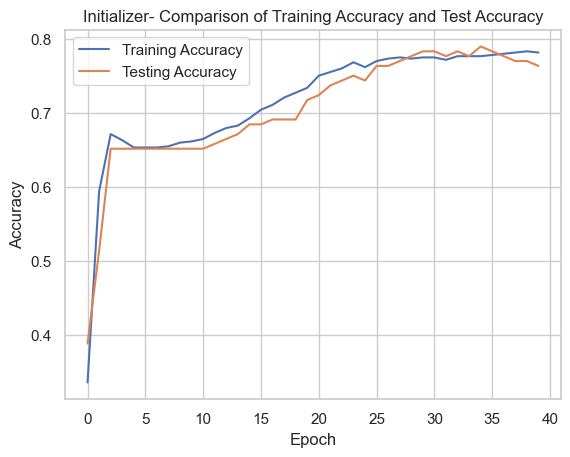

xavier initializer
Accuracy: 73.684


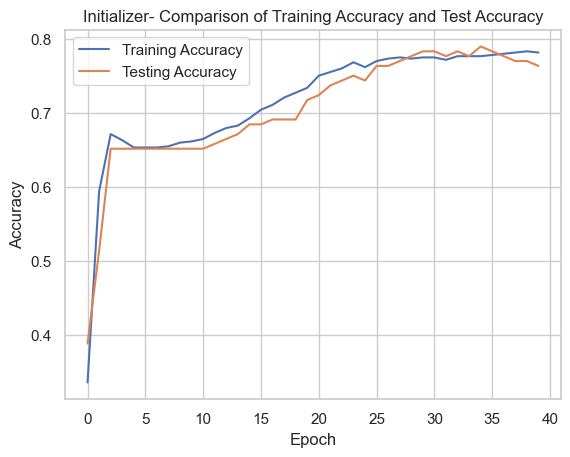

kaiming initializer
Accuracy: 74.342


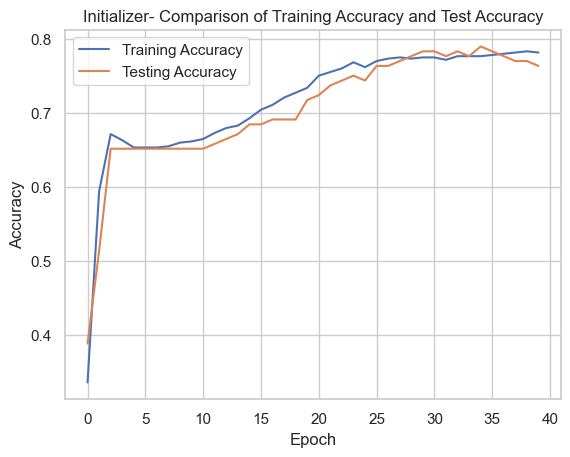

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim

# define the hyperparameters to tune
initializers = ['glorot', 'xavier', 'kaiming']
batch_size = 32
num_epochs = 50
learning_rate = 0.01

# loop through the different initializers and train the model
for inn in initializers:
    net = NeuralNetwork(inn)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            # get a batch of training data and labels
            inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
            labels = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.view(-1,1))
            loss.backward()
            optimizer.step()

    # evaluate the performance of the model on the testing data
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test.values)
        test_labels = torch.Tensor(y_test.values).view(-1,1)
        test_outputs = net(test_inputs)
            # convert probabilities to predicted labels
        predicted_labels = (test_outputs > 0.5).float()
    
        # calculate accuracy
        correct_predictions = (predicted_labels == test_labels).sum().item()
        total_predictions = len(test_labels)
        accuracy = correct_predictions *100/ total_predictions
        print(f'{inn} initializer')
        print('Accuracy: %.3f' % accuracy)
         # plot accuracy curves
        plt.plot(train_accuracy_list, label='Training Accuracy')
        plt.plot(test_accuracy_list, label='Testing Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Initializer- Comparison of Training Accuracy and Test Accuracy')
        plt.legend()
        plt.show()

###  Hyperparameter values selected 
Activation function selected is sigmoid at output<br>
Optimizer SGD<br>
Dropout 0<br>

###  Defining the Neural Network with above hyperparameter values to create a base model

In [246]:
class NeuralNetwork(nn.Module):

    def __init__(self, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(7, 64)
        self.hidden_layer1 = nn.Linear(64, 64)
        self.hidden_layer2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.output_activation = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        x = self.output_activation(self.hidden_layer2(x))
        return x

### Training the base model

In [247]:
# set up the training loop
num_epo = 40 
batch_size = 30
learning_rate = 0.01
dropout= 0
net = NeuralNetwork(dropout)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

base_train_loss_list = []
base_test_loss_list = []
base_accuracy_list = []
base_training_time_list = []
base_training_speed_list =[]

for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        # get a batch of training data and labels
        inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, label.view(-1,1))
        loss.backward()
        optimizer.step()
        
        # calculate statistics
        epo_loss += loss.item()        
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        test_data = torch.Tensor(y_test.iloc[i:i+batch_size].values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted data
        predicted = (test_output > 0.5).float()
        correct_predict += (predicted == test_data).sum().item()
    
    # calculate epoch train loss, test loss, training time and accuracy
    train_loss = epo_loss / len(X_train)
    test_loss = criterion(net(torch.Tensor(X_test.values)), 
                                torch.Tensor(y_test.values).view(-1,1)).item()
    accuracy = correct_predict*100 / len(X_test)
    
    # calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # calculate training speed
    training_speed = len(X_train) / training_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    base_train_loss_list.append(train_loss)
    base_test_loss_list.append(test_loss)
    base_accuracy_list.append(accuracy)
    base_training_time_list.append(training_time)
    base_training_speed_list.append(training_speed)
    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, accuracy: %.3f, Training time: %.3f sec, Training Speed: %.3f' % 
          (epoch + 1, train_loss, test_loss, accuracy, epo_time, training_speed))

#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test.values)
    test_data = torch.Tensor(y_test.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    Base_Total_accuracy = correct / len(test_data)
    
base_training_time= sum(base_training_time_list)
    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % base_test_loss_list[-1])
print('Total training time of model: %.3f sec' % base_training_time)
print('Total accuracy of model: %.3f' % Base_Total_accuracy)

Epoch 1 - Train_loss: 0.024, Test loss: 0.685, accuracy: 42.763, Training time: 0.086 sec, Training Speed: 9193.459
Epoch 2 - Train_loss: 0.024, Test loss: 0.675, accuracy: 65.789, Training time: 0.086 sec, Training Speed: 9187.497
Epoch 3 - Train_loss: 0.023, Test loss: 0.666, accuracy: 69.737, Training time: 0.086 sec, Training Speed: 9357.167
Epoch 4 - Train_loss: 0.023, Test loss: 0.658, accuracy: 66.447, Training time: 0.086 sec, Training Speed: 10587.895
Epoch 5 - Train_loss: 0.023, Test loss: 0.650, accuracy: 67.105, Training time: 0.086 sec, Training Speed: 8339.913
Epoch 6 - Train_loss: 0.022, Test loss: 0.643, accuracy: 67.105, Training time: 0.086 sec, Training Speed: 9265.981
Epoch 7 - Train_loss: 0.022, Test loss: 0.636, accuracy: 66.447, Training time: 0.086 sec, Training Speed: 12591.279
Epoch 8 - Train_loss: 0.022, Test loss: 0.629, accuracy: 66.447, Training time: 0.086 sec, Training Speed: 9284.806
Epoch 9 - Train_loss: 0.022, Test loss: 0.622, accuracy: 65.789, Train

### Save the weights of trainined base neural network model

In [248]:
# save the weights
torch.save(net.state_dict(), 'Vaishali_Jain_assignment2_part2.h5')

### Earlystopping method applied on base model

In [231]:
import time

# set up the training loop
num_epo = 40
batch_size = 30
learning_rate = 0.01
dropout = 0
net = NeuralNetwork(dropout)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# In the below list, train loss, test loss, accuracy and training time of each epoch will be saved
ES_train_loss_list = []
ES_test_loss_list = []
ES_accuracy_list = []
ES_training_time_list = []
ES_training_speed_list =[]

# early stopping variables
patience = 30
best_loss = float('inf')
counter = 0

# training loop
for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        # get a batch of training data and labels
        inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, label.view(-1,1))
        loss.backward()
        optimizer.step()
        
        # calculate statistics
        epo_loss += loss.item()        
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        test_data = torch.Tensor(y_test.iloc[i:i+batch_size].values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted data
        predicted = (test_output > 0.5).float()
        correct_predict += (predicted == test_data).sum().item()
    
    # calculate epoch train loss, test loss, training time and accuracy
    train_loss = epo_loss / len(X_train)
    test_loss = criterion(net(torch.Tensor(X_test.values)), 
                                torch.Tensor(y_test.values).view(-1,1)).item()
    accuracy = correct_predict*100 / len(X_test) 
    
    # calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # calculate training speed
    training_speed = len(X_train) / training_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    ES_train_loss_list.append(train_loss)
    ES_test_loss_list.append(test_loss)
    ES_accuracy_list.append(accuracy)
    ES_training_time_list.append(training_time)
    ES_training_speed_list.append(training_speed)
    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, accuracy: %.3f, Training time: %.3f sec, Training Speed: %.3f' % 
          (epoch + 1, train_loss, test_loss, accuracy, epo_time, training_speed))
    # check if loss has improved
    if epo_loss < best_loss:
        best_loss = epo_loss
        counter = 0
    else:
        counter += 1
    
    # check if early stopping criteria are met
    if counter == patience:
        print('Stopping early')
        break
    
    
#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test.values)
    test_data = torch.Tensor(y_test.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    ES_Total_accuracy = correct / len(test_data)
    
ES_training_time= sum(ES_training_time_list)
    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % ES_test_loss_list[-1])
print('Total training time of model: %.3f sec' % ES_training_time)
print('Total accuracy of model: %.3f' % ES_Total_accuracy)

Epoch 1 - Train_loss: 0.023, Test loss: 0.666, accuracy: 65.789, Training time: 0.083 sec, Training Speed: 9537.643
Epoch 2 - Train_loss: 0.023, Test loss: 0.656, accuracy: 67.105, Training time: 0.083 sec, Training Speed: 9284.062
Epoch 3 - Train_loss: 0.023, Test loss: 0.646, accuracy: 67.105, Training time: 0.083 sec, Training Speed: 9991.407
Epoch 4 - Train_loss: 0.022, Test loss: 0.638, accuracy: 66.447, Training time: 0.083 sec, Training Speed: 11194.631
Epoch 5 - Train_loss: 0.022, Test loss: 0.630, accuracy: 67.105, Training time: 0.083 sec, Training Speed: 9282.980
Epoch 6 - Train_loss: 0.022, Test loss: 0.622, accuracy: 67.105, Training time: 0.083 sec, Training Speed: 10678.518
Epoch 7 - Train_loss: 0.021, Test loss: 0.615, accuracy: 67.105, Training time: 0.083 sec, Training Speed: 10563.378
Epoch 8 - Train_loss: 0.021, Test loss: 0.608, accuracy: 67.763, Training time: 0.083 sec, Training Speed: 10494.088
Epoch 9 - Train_loss: 0.021, Test loss: 0.601, accuracy: 68.421, Tra

### Plot for Comparison  of Accuracy of Earlystoppimg method model from base model

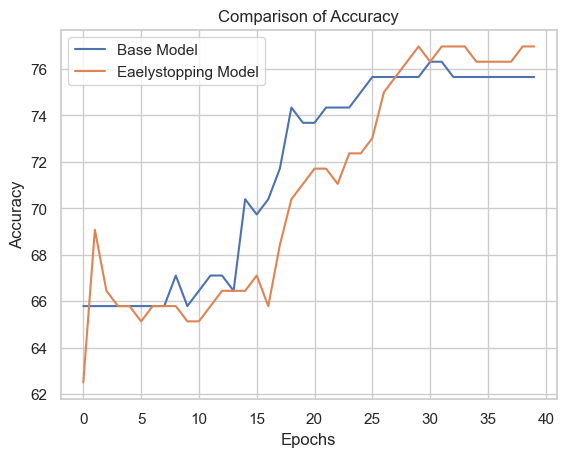

In [171]:
# Plot test accuracy for base model and improved version
plt.plot(base_accuracy_list, label='Base Model')
plt.plot(ES_accuracy_list, label='Eaelystopping Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

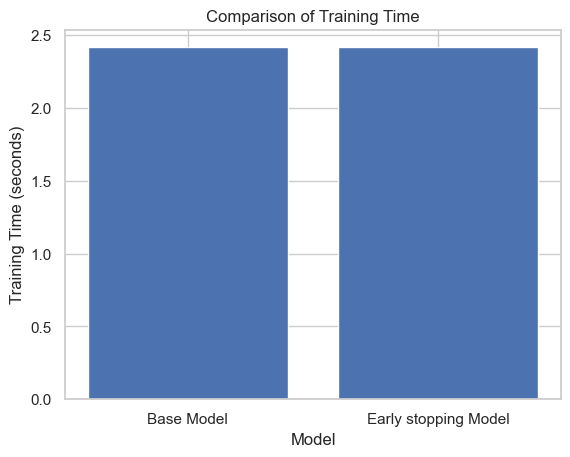

In [172]:
# Plot training time for base model and improved version
plt.bar(['Base Model', 'Early stopping Model'], [base_training_time, ES_training_time])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Time')
plt.show()


###  K-fold cross-validation with fold = 5

In [181]:
from statistics import mean

class NeuralNetwork(nn.Module):

    def __init__(self, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(7, 64)
        self.hidden_layer1 = nn.Linear(64, 64)
        self.hidden_layer2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.xavier_normal_(self.hidden_layer1.weight)
        nn.init.xavier_normal_(self.hidden_layer2.weight)
        self.output_activation = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        x = self.output_activation(self.hidden_layer2(x))
        return x

def get_fold_data(X, y, fold, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kf.split(X))
    train_idx, test_idx = folds[fold]
    X_train1, y_train1 = X.iloc[train_idx], y.iloc[train_idx]
    X_test1, y_test1 = X.iloc[test_idx], y.iloc[test_idx]
    return X_train1, y_train1, X_test1, y_test1


In [182]:
from sklearn.model_selection import KFold
# define k
k = 5

kfold_train_loss_list = []
kfold_test_loss_list = []
kfold_accuracy_list = []
kfold_training_time_list = []
kfold_training_speed_list =[]


# set up the training loop
num_epo = 40 
batch_size = 30
learning_rate = 0.01
dropout = 0
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    start_time = time.time()
    
    for fold in range(k):
        # define lists to store the accuracy and loss
        each_fold_train_loss_list = []
        each_fold_test_loss_list = []
        each_fold_accuracy_list = []
        each_fold_training_time_list = []
        each_fold_training_speed_list =[]
        # get the training and validation data for the current fold
        X_train1, y_train1, X_test1, y_test1 = get_fold_data(X, y, fold, k)
        
        for i in range(0, len(X_train1), batch_size):
            # get a batch of training data and labels
            inputs = torch.Tensor(X_train1.iloc[i:i+batch_size].values)
            label = torch.Tensor(y_train1.iloc[i:i+batch_size].values)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(inputs)
            loss = criterion(output, label.view(-1,1))
            loss.backward()
            optimizer.step()
        
            # calculate statistics
            epo_loss += loss.item()        
            test_input = torch.Tensor(X_test1.iloc[i:i+batch_size].values)
            test_data = torch.Tensor(y_test1.iloc[i:i+batch_size].values).view(-1,1)
            test_output = net(test_input)
            # convert probabilities to predicted data
            predicted = (test_output > 0.5).float()
            correct_predict += (predicted == test_data).sum().item()
    
        # calculate epoch train loss, test loss, training time and accuracy
        train_loss = epo_loss / len(X_train1)
        test_loss = criterion(net(torch.Tensor(X_test1.values)), 
                                torch.Tensor(y_test1.values).view(-1,1)).item()
        accuracy = correct_predict*100 / len(X_test1)
    
        # calculate training time
        end_time = time.time()
        training_time = end_time - start_time
    
        # calculate training speed
        training_speed = len(X_train1) / training_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    each_fold_train_loss_list.append(train_loss)
    each_fold_test_loss_list.append(test_loss)
    each_fold_accuracy_list.append(accuracy)
    each_fold_training_time_list.append(training_time)
    each_fold_training_speed_list.append(training_speed)
    
    accuracy = sum(each_fold_accuracy_list)/k
    train_loss = sum(each_fold_train_loss_list)/k
    test_loss = sum(each_fold_test_loss_list)/k
    training_time = sum(each_fold_training_time_list)/k
    training_speed = sum(each_fold_training_speed_list)/k
    
    

    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, accuracy: %.3f, Training time: %.3f sec, Training Speed: %.3f' % 
          (epoch + 1, train_loss, test_loss, accuracy, training_time, training_speed))
    
    # append the loss, accuracy and training time of a epoch  and also print 
    kfold_train_loss_list.append(train_loss)
    kfold_test_loss_list.append(test_loss)
    kfold_accuracy_list.append(accuracy)
    kfold_training_time_list.append(training_time)
    kfold_training_speed_list.append(training_speed)
    

#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test1.values)
    test_data = torch.Tensor(y_test1.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    kfold_Total_accuracy = correct / len(test_data)
    
kfold_training_time= sum(kfold_training_time_list)
    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % kfold_test_loss_list[-1])
print('Total training time of model: %.3f sec' % kfold_training_time)
print('Total accuracy of model: %.3f' % kfold_Total_accuracy)



Epoch 1 - Train_loss: 0.014, Test loss: 0.084, accuracy: 79.342, Training time: 0.064 sec, Training Speed: 377.530
Epoch 2 - Train_loss: 0.014, Test loss: 0.084, accuracy: 79.342, Training time: 0.065 sec, Training Speed: 373.279
Epoch 3 - Train_loss: 0.014, Test loss: 0.084, accuracy: 79.342, Training time: 0.064 sec, Training Speed: 382.855
Epoch 4 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.342, Training time: 0.062 sec, Training Speed: 392.286
Epoch 5 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.474, Training time: 0.065 sec, Training Speed: 373.173
Epoch 6 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.474, Training time: 0.065 sec, Training Speed: 373.563
Epoch 7 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.474, Training time: 0.065 sec, Training Speed: 372.067
Epoch 8 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.605, Training time: 0.068 sec, Training Speed: 358.647
Epoch 9 - Train_loss: 0.014, Test loss: 0.083, accuracy: 79.737, Training time: 

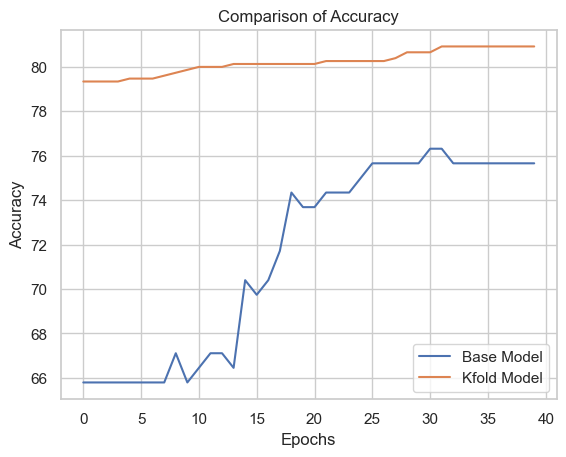

In [183]:
import matplotlib.pyplot as plt

# Plot test accuracy for base model and improved version
plt.plot(base_accuracy_list, label='Base Model')
plt.plot(kfold_accuracy_list, label='Kfold Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

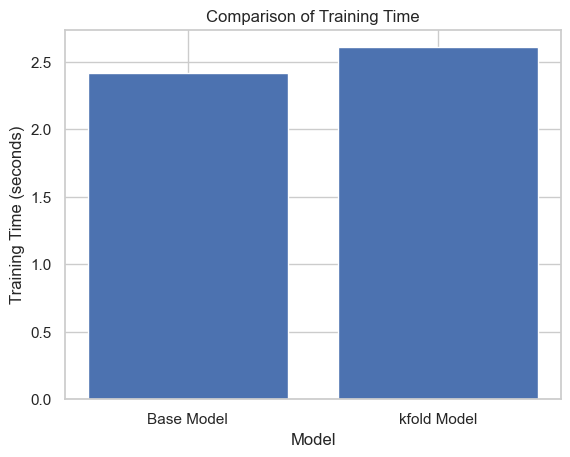

In [185]:
# Plot training time for base model and improved version
plt.bar(['Base Model', 'kfold Model'], [base_training_time, kfold_training_time])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Time')
plt.show()


###  learning rate scheduler

In [186]:
num_epo = 40 
batch_size = 30
learning_rate = 0.01
dropout= 0
net = NeuralNetwork(dropout)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # learning rate scheduler

LRS_train_loss_list = []
LRS_test_loss_list = []
LRS_accuracy_list = []
LRS_training_time_list = []
LRS_training_speed_list =[]

for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        # get a batch of training data and labels
        inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, label.view(-1,1))
        loss.backward()
        optimizer.step()
        
        # calculate statistics
        epo_loss += loss.item()        
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        test_data = torch.Tensor(y_test.iloc[i:i+batch_size].values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted data
        predicted = (test_output > 0.5).float()
        correct_predict += (predicted == test_data).sum().item()
        
        
    scheduler.step() # update learning rate after each epoch
    
    # calculate epoch train loss, test loss, training time and accuracy
    train_loss = epo_loss / len(X_train)
    test_loss = criterion(net(torch.Tensor(X_test.values)), 
                                torch.Tensor(y_test.values).view(-1,1)).item()
    accuracy = correct_predict*100 / len(X_test)
    
    # calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # calculate training speed
    training_speed = len(X_train) / training_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    LRS_train_loss_list.append(train_loss)
    LRS_test_loss_list.append(test_loss)
    LRS_accuracy_list.append(accuracy)
    LRS_training_time_list.append(training_time)
    LRS_training_speed_list.append(training_speed)
    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, accuracy: %.3f, Training time: %.3f sec, Training Speed: %.3f' % 
          (epoch + 1, train_loss, test_loss, accuracy, epo_time, training_speed))

#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test.values)
    test_data = torch.Tensor(y_test.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    LRS_Total_accuracy = correct / len(test_data)
    
LRS_training_time= sum(LRS_training_time_list)
    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % LRS_test_loss_list[-1])
print('Total training time of model: %.3f sec' % LRS_training_time)
print('Total accuracy of model: %.3f' % LRS_Total_accuracy)
    



Epoch 1 - Train_loss: 0.025, Test loss: 0.675, accuracy: 50.658, Training time: 0.108 sec, Training Speed: 10639.490
Epoch 2 - Train_loss: 0.023, Test loss: 0.650, accuracy: 62.500, Training time: 0.108 sec, Training Speed: 9260.799
Epoch 3 - Train_loss: 0.023, Test loss: 0.631, accuracy: 66.447, Training time: 0.108 sec, Training Speed: 10704.156
Epoch 4 - Train_loss: 0.022, Test loss: 0.615, accuracy: 65.132, Training time: 0.108 sec, Training Speed: 9306.661
Epoch 5 - Train_loss: 0.021, Test loss: 0.603, accuracy: 66.447, Training time: 0.108 sec, Training Speed: 9422.999
Epoch 6 - Train_loss: 0.021, Test loss: 0.591, accuracy: 67.105, Training time: 0.108 sec, Training Speed: 9318.564
Epoch 7 - Train_loss: 0.020, Test loss: 0.581, accuracy: 67.763, Training time: 0.108 sec, Training Speed: 9338.698
Epoch 8 - Train_loss: 0.020, Test loss: 0.573, accuracy: 68.421, Training time: 0.108 sec, Training Speed: 9274.675
Epoch 9 - Train_loss: 0.020, Test loss: 0.565, accuracy: 69.079, Train

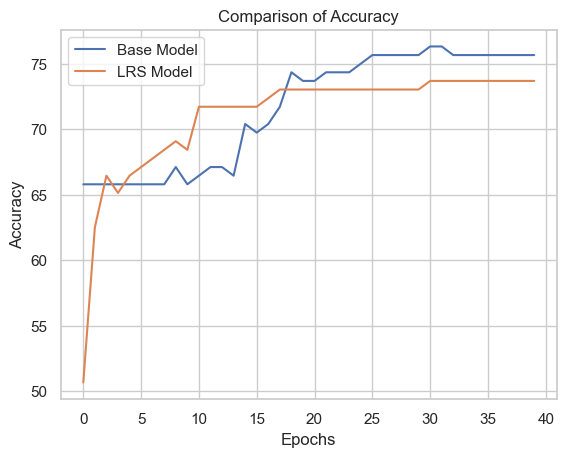

In [187]:
import matplotlib.pyplot as plt

# Plot test accuracy for base model and improved version
plt.plot(base_accuracy_list, label='Base Model')
plt.plot(LRS_accuracy_list, label='LRS Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

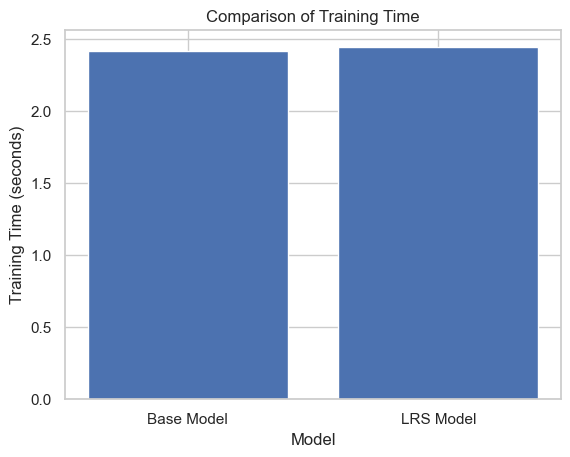

In [189]:
# Plot training time for base model and improved version
plt.bar(['Base Model', 'LRS Model'], [base_training_time, LRS_training_time])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Time')
plt.show()


### Batch Normalisation 

In [190]:
class NeuralNetwork(nn.Module):

    def __init__(self, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(7, 64)
        self.hidden_layer1 = nn.Linear(64, 64)
        self.hidden_layer2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.xavier_normal_(self.hidden_layer1.weight)
        nn.init.xavier_normal_(self.hidden_layer2.weight)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.output_activation = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.bn1(self.relu(self.input_layer(x)))
        x = self.bn2(self.relu(self.hidden_layer1(x)))
        x = self.dropout(x)
        x = self.output_activation(self.hidden_layer2(x))
        return x

In [204]:
# set up the training loop
num_epo = 40 
batch_size = 30
learning_rate = 0.01
dropout= 0
net = NeuralNetwork(dropout)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

BN_train_loss_list = []
BN_test_loss_list = []
BN_accuracy_list = []
BN_training_time_list = []
BN_training_speed_list =[]

for epoch in range(num_epo):
    epo_loss = 0.0
    correct_predict = 0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        # get a batch of training data and labels
        inputs = torch.Tensor(X_train.iloc[i:i+batch_size].values)
        label = torch.Tensor(y_train.iloc[i:i+batch_size].values)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, label.view(-1,1))
        loss.backward()
        optimizer.step()
        
        # calculate statistics
        epo_loss += loss.item()        
        test_input = torch.Tensor(X_test.iloc[i:i+batch_size].values)
        test_data = torch.Tensor(y_test.iloc[i:i+batch_size].values).view(-1,1)
        test_output = net(test_input)
        # convert probabilities to predicted data
        predicted = (test_output > 0.5).float()
        correct_predict += (predicted == test_data).sum().item()
    
    # calculate epoch train loss, test loss, training time and accuracy
    train_loss = epo_loss / len(X_train)
    test_loss = criterion(net(torch.Tensor(X_test.values)), 
                                torch.Tensor(y_test.values).view(-1,1)).item()
    accuracy = correct_predict*100 / len(X_test)
    
    # calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # calculate training speed
    training_speed = len(X_train) / training_time
    
    # append the loss, accuracy and training time of a epoch  and also print 
    BN_train_loss_list.append(train_loss)
    BN_test_loss_list.append(test_loss)
    BN_accuracy_list.append(accuracy)
    BN_training_time_list.append(training_time)
    BN_training_speed_list.append(training_speed)
    print('Epoch %d - Train_loss: %.3f, Test loss: %.3f, accuracy: %.3f, Training time: %.3f sec, Training Speed: %.3f' % 
          (epoch + 1, train_loss, test_loss, accuracy, epo_time, training_speed))

#Calculate total accuracy of model 
with torch.no_grad():
    test_input = torch.Tensor(X_test.values)
    test_data = torch.Tensor(y_test.values).view(-1,1)
    test_output = net(test_input)
    # convert probabilities to predicted labels
    predictions = (test_output > 0.5).float()
    
    # calculate accuracy
    correct= (predictions == test_data).sum().item()
    BN_Total_accuracy = correct / len(test_data)
    
BN_training_time= sum(BN_training_time_list)
    
# print final test loss, accuracy and training time
print('Final test loss: %.3f' % BN_test_loss_list[-1])
print('Total training time of model: %.3f sec' % BN_training_time)
print('Total accuracy of model: %.3f' % BN_Total_accuracy)

Epoch 1 - Train_loss: 0.024, Test loss: 0.665, accuracy: 57.237, Training time: 0.108 sec, Training Speed: 6248.436
Epoch 2 - Train_loss: 0.020, Test loss: 0.626, accuracy: 62.500, Training time: 0.108 sec, Training Speed: 7390.137
Epoch 3 - Train_loss: 0.018, Test loss: 0.612, accuracy: 68.421, Training time: 0.108 sec, Training Speed: 6715.481
Epoch 4 - Train_loss: 0.017, Test loss: 0.602, accuracy: 70.395, Training time: 0.108 sec, Training Speed: 7504.066
Epoch 5 - Train_loss: 0.016, Test loss: 0.593, accuracy: 71.053, Training time: 0.108 sec, Training Speed: 6866.337
Epoch 6 - Train_loss: 0.016, Test loss: 0.587, accuracy: 73.026, Training time: 0.108 sec, Training Speed: 6737.500
Epoch 7 - Train_loss: 0.015, Test loss: 0.583, accuracy: 72.368, Training time: 0.108 sec, Training Speed: 7475.075
Epoch 8 - Train_loss: 0.015, Test loss: 0.579, accuracy: 72.368, Training time: 0.108 sec, Training Speed: 7476.916
Epoch 9 - Train_loss: 0.014, Test loss: 0.577, accuracy: 73.026, Trainin

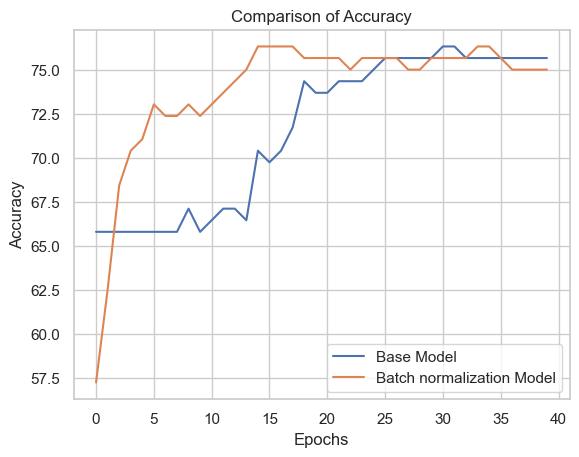

In [205]:
import matplotlib.pyplot as plt

# Plot test accuracy for base model and improved version
plt.plot(base_accuracy_list, label='Base Model')
plt.plot(BN_accuracy_list, label='Batch normalization Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

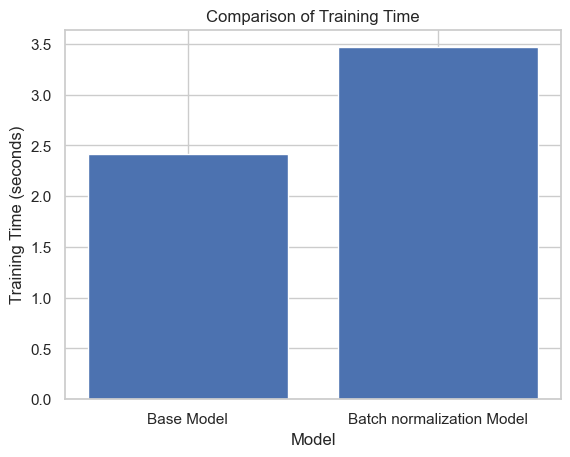

In [206]:
# Plot training time for base model and improved version
plt.bar(['Base Model', 'Batch normalization Model'], [base_training_time, BN_training_time])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Time')
plt.show()
